In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [2]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Add, Activation, Dropout

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
tf.Tensor(-1727.2825, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-22 22:42:14.146331: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-22 22:42:14.568628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


------------
ResNet - Residual Network
- usage of residual connections.

### 1. `conv3d_block` Function:
This function creates a basic building block of the network consisting of two 3D convolutional layers. Each convolutional layer is followed by batch normalization and a ReLU activation.

- **3D Convolution (Conv3D)**: Applies a 3D convolution operation. It is defined as `Conv3D(filters, kernel_size, padding='same')`. Here, `filters` specify the number of output filters in the convolution, `kernel_size` is the size of the 3D convolution window (in this case, a 4x4x4 cube), and `padding='same'` ensures the output has the same dimensions as the input.
- **Batch Normalization (BatchNormalization)**: Normalizes the activations of the previous layer at each batch, maintaining the mean activation close to 0 and the activation standard deviation close to 1. This helps in accelerating training and reducing the importance of initialization.
- **ReLU Activation (ReLU)**: Applies the rectified linear unit activation function, which introduces non-linearity to the model. It's defined as `f(x) = max(0, x)`.

### 2. `identity_block` Function:
This function creates an identity block, a type of residual block where the input is added directly to the output of the convolutional block.

- **Residual Connection**: The function adds (`Add()`) the input tensor `tensor` to the output of `conv3d_block`. This helps in mitigating the vanishing gradient problem in deep networks.
- **ReLU Activation**: After adding, another ReLU activation is applied.

### 3. `projection_block` Function:
This is another type of residual block which includes a projection shortcut, used when the dimensions of the input and output do not match.

- **Projection Shortcut**: Before adding the input to the output of `conv3d_block`, the input tensor is first passed through a 3D convolutional layer with a 1x1x1 kernel to match the dimensions.
- **Add and ReLU**: Similar to the `identity_block`.

### 4. `resnet_block` Function:
This function creates a ResNet block with an optional downsampling.

- **Downsampling (Optional)**: If `downsample=True`, the function applies a convolution with a stride of 2 to the input tensor, effectively reducing its dimensions by half. This is followed by batch normalization and a ReLU activation.
- **Convolutional Block and Residual Connection**: It then applies a `conv3d_block` and adds its output to the (optionally downsampled) input tensor, followed by a ReLU activation.

### Mathematical Explanation:

In mathematical terms, let's represent the operations as follows:

- Convolution: $( C(x) )$
- Batch Normalization: $( BN(x) )$
- ReLU Activation: $( \text{ReLU}(x) = \max(0, x) )$

For `conv3d_block`:
- Output: $( \text{ReLU}(BN(C(\text{ReLU}(BN(C(x)))))) )$

For `identity_block`:
- Output: $( \text{ReLU}(x + C_{block}(x))), where ( C_{block}(x) )$ is the output of `conv3d_block`.

For `projection_block`:
- Output: $( \text{ReLU}(C(x) + C_{block}(x))), with a projection convolution ( C(x) )$.

For `resnet_block` with `downsample=True`:
- Intermediate: \( x' = \text{ReLU}(BN(C(x))) \) (downsampled input)
- Output: $( \text{ReLU}(x' + C_{block}(x')) )$

These residual connections help in training deeper networks by allowing gradients to flow through the network directly, bypassing several layers. This architecture has been revolutionary in deep learning, especially in computer vision tasks, due to its effectiveness in solving the problem of vanishing gradients in deep networks.

-----

In [4]:
from tensorflow.keras.layers import Conv3D, Add, ReLU, BatchNormalization
from tensorflow.keras import Input, Model

def conv3d_block(x, filters):
    conv_1 = Conv3D(filters, 4, padding='same')(x)
    norm_1 = BatchNormalization()(conv_1)
    relu_1 = ReLU()(norm_1)
    conv_2 = Conv3D(filters, 4, padding='same')(relu_1)
    norm_2 = BatchNormalization()(conv_2)
    return norm_2

def identity_block(tensor, filters):
    x = conv3d_block(tensor, filters)
    output = Add()([x, tensor])
    output = ReLU()(output)
    return output

def projection_block(tensor, filters):
    x = conv3d_block(tensor, filters)
    projection = Conv3D(filters, 1, padding='same')(tensor)
    output = Add()([x, projection])
    output = ReLU()(output)
    return output

def resnet_block(x, filters, downsample=False):
    if downsample:
        x = Conv3D(filters, 1, strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
    y = conv3d_block(x, filters)
    y = Add()([y, x])
    y = ReLU()(y)
    return y

In [5]:
data = np.load('./generated_data/simulated_data_020124_150K.npy')

In [6]:
os.environ['PYTHONHASHSEED']=str(123)

np.random.seed(123)
tf.random.set_seed(123)

In [7]:
# Split the data
initial_state = data[:, 0]
final_state = data[:, 1]

# Compute the mean and std of the initial and final states
initial_state_mean, initial_state_std = np.mean(initial_state), np.std(initial_state)
final_state_mean, final_state_std = np.mean(final_state), np.std(final_state)

# Normalize the initial and final states
initial_state = (initial_state - initial_state_mean) / initial_state_std
final_state = (final_state - final_state_mean) / final_state_std

# Select one simulation's initial and final states
initial_conditions = initial_state[0]
final_density = final_state[0]

In [8]:
# train and test
X_train, X_test, y_train, y_test  = train_test_split(initial_state, final_state, test_size=0.15, random_state=123)

# further splitting it in training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=123)

In [9]:
# Recasting dimensions to 4D tensor (suitable for 3D convolutions) with the following dimensions: (batch_size, height, width, depth, num_channels)
X_train = np.reshape(X_train, (*X_train.shape, 1))
X_val = np.reshape(X_val, (*X_val.shape, 1))
X_test = np.reshape(X_test, (*X_test.shape, 1))

y_train = np.reshape(y_train, (*y_train.shape, 1))
y_val = np.reshape(y_val, (*y_val.shape, 1))
y_test = np.reshape(y_test, (*y_test.shape, 1))

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((108375, 32, 32, 32, 1),
 (108375, 32, 32, 32, 1),
 (19125, 32, 32, 32, 1),
 (19125, 32, 32, 32, 1),
 (22500, 32, 32, 32, 1),
 (22500, 32, 32, 32, 1))

In [10]:
# Parameters
Ngrid = 32  # grid size

In [11]:
input_shape = (Ngrid, Ngrid, Ngrid, 1)
input_tensor = Input(shape=input_shape)

x = resnet_block(input_tensor, filters=64)

# adding it for single channel
res_block = Conv3D(1, (1, 1, 1), activation='linear')(x)

res_model = Model(inputs=input_tensor, outputs=res_block)

In [12]:
# Compile the model
res_model.compile(optimizer=Adam(), 
                   loss='mse',
                   metrics=['mae'],
                   run_eagerly=True)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=5, 
                              min_lr=0.001)
checkpoint = ModelCheckpoint('resnet_5K.hdf5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True)

In [14]:
history = res_model.fit(x=X_train, 
                         y=y_train, 
                         validation_data=(X_val, y_val), 
                         batch_size=32, 
                         epochs=50, 
                         callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/50


2024-01-22 00:05:44.723817: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2024-01-22 00:05:46.904753: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3387/3387 [==============================] - ETA: 0s - loss: 0.4148 - mae: 0.4356
Epoch 1: val_loss improved from inf to 0.39239, saving model to resnet_5K.hdf5
3387/3387 [==============================] - 233s 68ms/step - loss: 0.4148 - mae: 0.4356 - val_loss: 0.3924 - val_mae: 0.4202 - lr: 0.0010
Epoch 2/50
3387/3387 [==============================] - ETA: 0s - loss: 0.3904 - mae: 0.4190
Epoch 2: val_loss improved from 0.39239 to 0.38900, saving model to resnet_5K.hdf5
3387/3387 [==============================] - 227s 67ms/step - loss: 0.3904 - mae: 0.4190 - val_loss: 0.3890 - val_mae: 0.4183 - lr: 0.0010
Epoch 3/50
3386/3387 [============================>.] - ETA: 0s - loss: 0.3877 - mae: 0.4169
Epoch 3: val_loss improved from 0.38900 to 0.38827, saving model to resnet_5K.hdf5
3387/3387 [==============================] - 227s 67ms/step - loss: 0.3877 - mae: 0.4169 - val_loss: 0.3883 - val_mae: 0.4213 - lr: 0.0010
Epoch 4/50
3387/3387 [==============================] - ETA: 0s - loss

In [15]:
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 32,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 32, 32, 32,   4160        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32,   256        ['conv3d[0][0]']                 
 alization)                     64)                                                           

------

In [11]:
# loading resnet3D model because instance crashed

from tensorflow.keras.models import load_model
res_model = load_model('resnet_5K.hdf5') # unfortunately, the name was not updated, the model is trained on 150K.

In [12]:
eval_results = res_model.evaluate(x=X_test, y=y_test)
print(f"Evaluation Results:{eval_results}")

2024-01-22 23:00:21.781961: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


704/704 [==============================] - 24s 14ms/step - loss: 0.3808 - mae: 0.4118
Evaluation Results:[0.38080981373786926, 0.4118342995643616]


In [13]:
predictions = res_model.predict(X_test)
predictions.shape

(22500, 32, 32, 32, 1)

In [14]:
vmin = min(np.min(predictions), np.min(X_test))
vmax = max(np.max(predictions), np.max(X_test))

vmin, vmax

(-6.37655171866268, 15.400403)

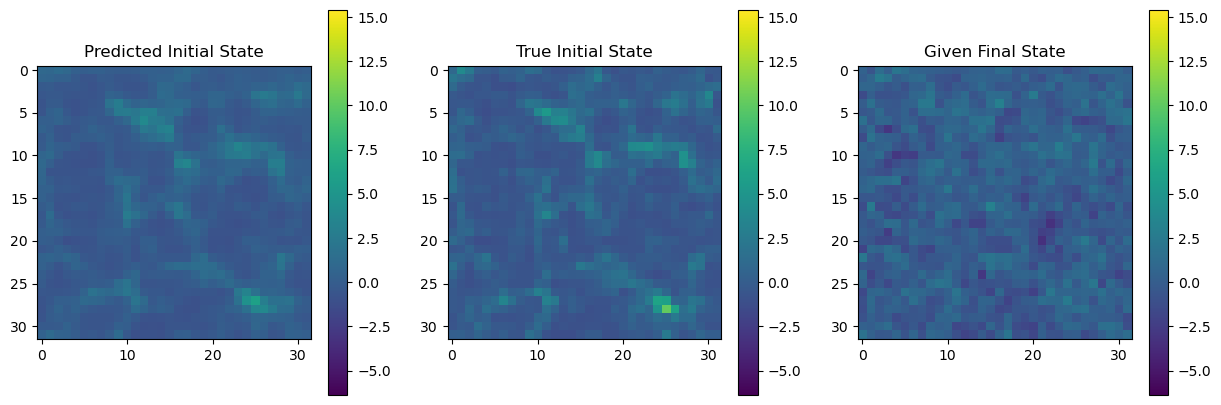

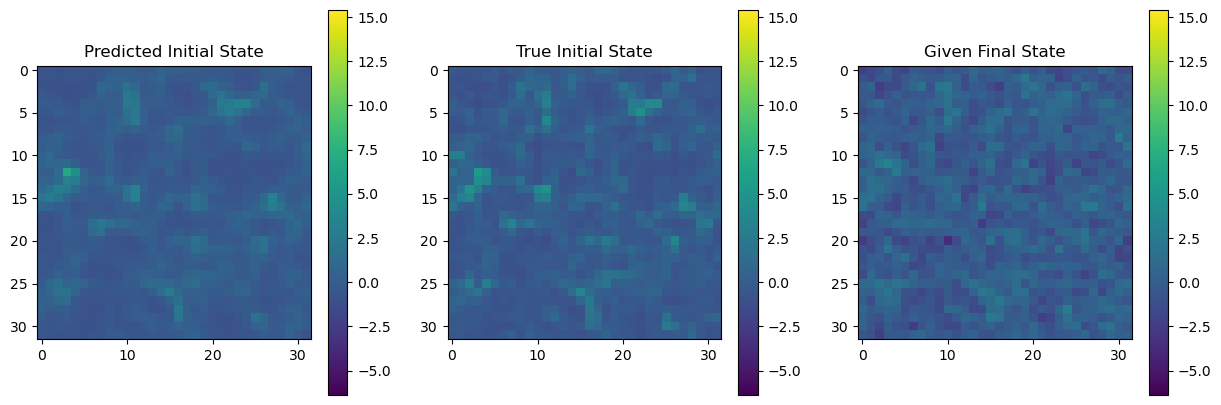

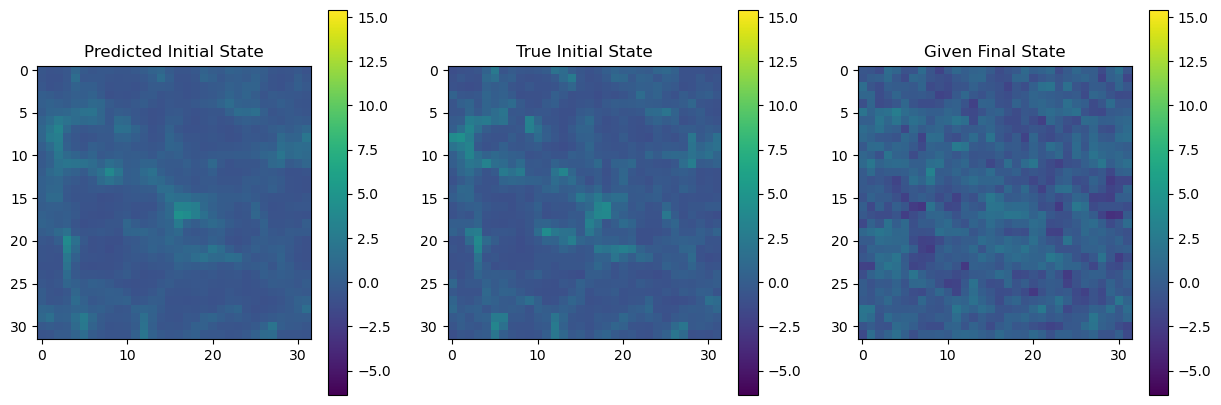

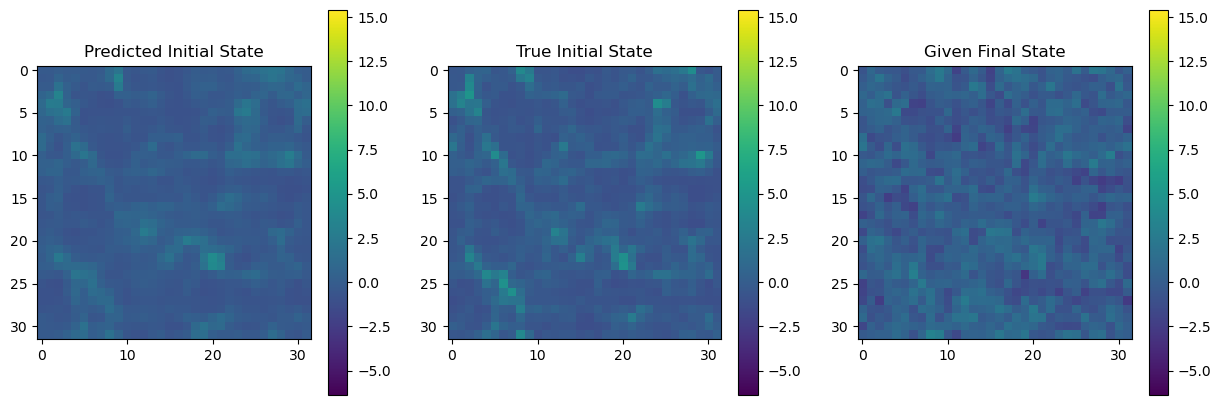

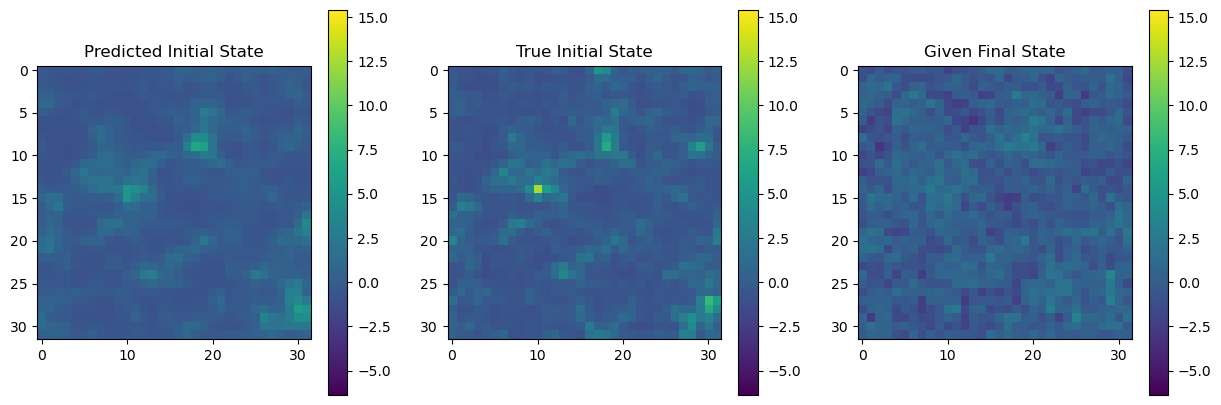

In [15]:
for test_index in range(5):  # Plot first 5 test cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot predicted initial state
    im = axs[0].imshow(predictions[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], 
                       vmin=vmin, 
                       vmax=vmax,
                       cmap='viridis')
    axs[0].set_title('Predicted Initial State')
    fig.colorbar(im, ax=axs[0])

    # Plot true initial state
    im = axs[1].imshow(y_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], 
                       vmin=vmin, 
                       vmax=vmax,
                       cmap='viridis')
    axs[1].set_title('True Initial State')
    fig.colorbar(im, ax=axs[1])

    # Plot given final state 
    im = axs[2].imshow(X_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], 
                       vmin=vmin, 
                       vmax=vmax, 
                       cmap='viridis')
    axs[2].set_title('Given Final State')
    fig.colorbar(im, ax=axs[2])

    plt.show()

In [16]:
# calculating the error metrics
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
mae = mean_absolute_error(y_test.flatten(), predictions.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.3808098551354075
Mean Absolute Error (MAE): 0.4118341858037919


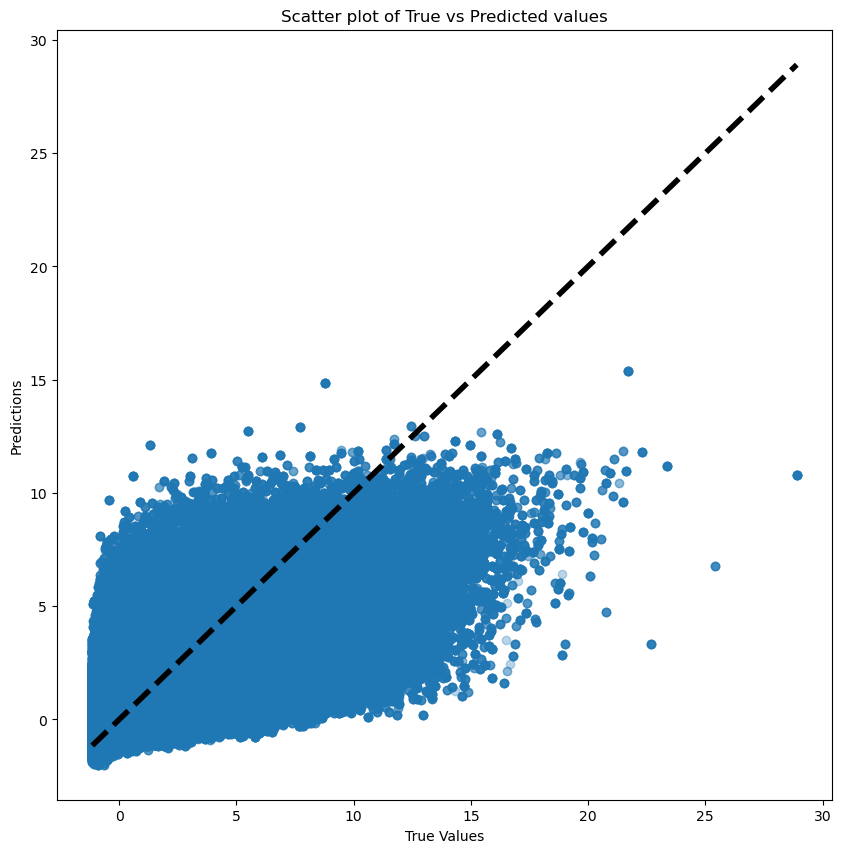

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.3) 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter plot of True vs Predicted values')
plt.show()

## Script Complete